<a href="https://colab.research.google.com/github/ganeshhep/JETS/blob/main/task_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations

In [1]:
!pip install uproot
!pip install fastjet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.3/351.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 791.3/791.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.8/692.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 15.9 MB/s eta 0:00:00


## Imports

In [2]:
import itertools
import uproot
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm, sorted_by_pt, join
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Loading the data
from google.colab import drive
drive.mount('/content/drive')
data_file = "/content/drive/MyDrive/tutorial5_new.root"

Mounted at /content/drive


In [4]:
tree = uproot.open(data_file)['tree']

In [5]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
event                | int32_t                  | AsDtype('>i4')
may_decay            | int8_t                   | AsDtype('int8')
isLepton             | int8_t                   | AsDtype('int8')
isbHadron            | int8_t                   | AsDtype('int8')
px                   | double                   | AsDtype('>f8')
py                   | double                   | AsDtype('>f8')
pz                   | double                   | AsDtype('>f8')
e                    | double                   | AsDtype('>f8')
pT                   | double                   | AsDtype('>f8')


In [6]:
tree.num_entries # This is the sum total of number of all the particles obtained at the final state of all the events.

83815921

In [7]:
table = tree.arrays(library = 'ak') # a list of dictionaries

In [25]:
def f(R) : # R is the radius parameter
  n_jets = [] # a list containing number of jets in each event
  n_bjets = [] # a list containing number of b-jets in each event
  jet_pT = [] # a list containing jets pT
  jet_eta = [] # a list containing jets eta
  w_jet_inv_mass = [] # a list containing invariant masses of w-jets

  N = 1000 # number of events

  for n in range(N) : # taking upto N events
      bHadrons_list = [] # a list of b-hadrons in an event
      particles_list = [] # a list of particles in an event
      jet_list = [] # a list of jets in an event
      b_jets_list = [] # a list of b-jets in an event

      n_b = 0 # n is the number of b-jets in an event

      event_n = table[table['event'] == n]

      bHadrons = event_n[event_n['isbHadron'] == 1]
      stable_list = event_n[event_n['may_decay'] == 0]
      particles = stable_list[stable_list['isLepton'] == 0] # the list contains stable particles and no leptons are included

      for i in range(len(bHadrons)) :
        bHadron_p4 = PseudoJet(bHadrons[i]['px'], bHadrons[i]['py'], bHadrons[i]['pz'], bHadrons[i]['e'])
        bHadrons_list.append(bHadron_p4)

      for j in range(len(particles)) : # looping over the particles in an event
        part_p4 = PseudoJet(particles[j]['px'], particles[j]['py'], particles[j]['pz'], particles[j]['e'])
        particles_list.append(part_p4)

      # Applying clustering of particles with anti-kt algorithm
      cluster = ClusterSequence(particles_list, JetDefinition(antikt_algorithm, R))
      jet_set = sorted_by_pt(cluster.inclusive_jets(ptmin = 10.0)) # Jets obtained from inclusive form of clustering algorithm, sorted by pT (decreasing pT) and pT > 10.0 GeV

      for k in range(len(jet_set)) : # looping over jets
          jet_p4 = jet_set[k]
          jet_list.append(jet_p4)
          jet_pT.append(jet_p4.pt())
          jet_eta.append(jet_p4.eta())

          for l in range(len(bHadrons_list)) :
            b_hadron_p4 = bHadrons_list[l]
            del_R = ((jet_p4.eta() - b_hadron_p4.eta())**2 + (jet_p4.phi() - b_hadron_p4.phi())**2)**0.5
            if del_R < R :
              n_b += 1
              jet_list.remove(jet_p4)
              b_jets_list.append(jet_p4)
              break

      # jet_list now contains non b-jets set. From this list, we identify w-jets.

      non_b_jet_list = jet_list

      # Identifying w-jet
      if len(non_b_jet_list) > 1 :
       for p in range(1, len(non_b_jet_list)) :
          d_R = 1000
          s = 0
          for q in range(p, len(non_b_jet_list)) :
            dijet = non_b_jet_list[p - 1] + non_b_jet_list[q]
            dijet_mass = dijet.m()
            delta_R = ((non_b_jet_list[p - 1].eta() - non_b_jet_list[q].eta())**2 + (non_b_jet_list[p - 1].phi() - non_b_jet_list[q].phi())**2)**0.5
            if dijet_mass > 70 and dijet_mass < 90 :
              s = 1
              if delta_R < d_R :
                t = q
                d_R = delta_R
                mass = dijet_mass

          if s == 1 :
            non_b_jet_list.remove(non_b_jet_list[t])
            w_jet_inv_mass.append(mass)

      n_jets.append(len(jet_set))
      n_bjets.append(n_b)

  plt.hist(n_jets, bins = np.arange(0, 15), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("Number of jets")
  plt.ylabel("Number of events")
  plt.legend()
  plt.show()

  plt.hist(np.log(jet_pT), bins = np.arange(0, 11), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("log(pT)")
  plt.legend()
  plt.show()

  plt.hist(jet_eta, bins = np.arange(-10, 10), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("Jet-eta")
  plt.legend()
  plt.show()

  plt.hist(n_bjets, bins = np.arange(0, 15), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("Number of b-jets")
  plt.ylabel("Number of events")
  plt.legend()
  plt.show()

  plt.hist(w_jet_inv_mass, bins = np.arange(65, 95), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("invariant mass of w-jets")
  plt.legend()
  plt.show()

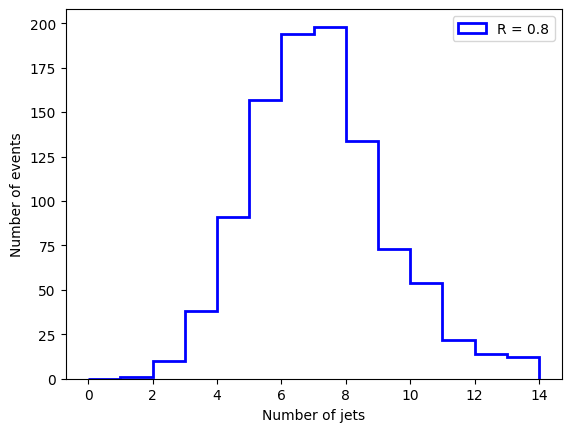

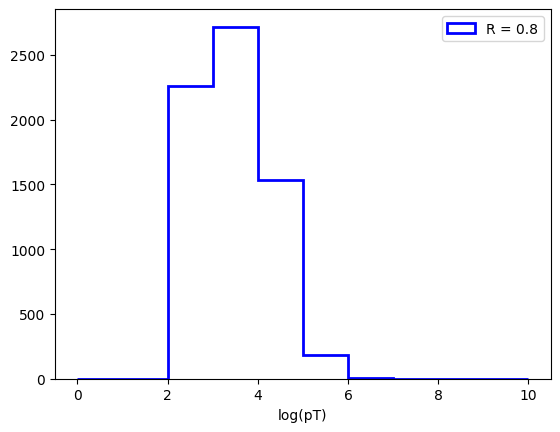

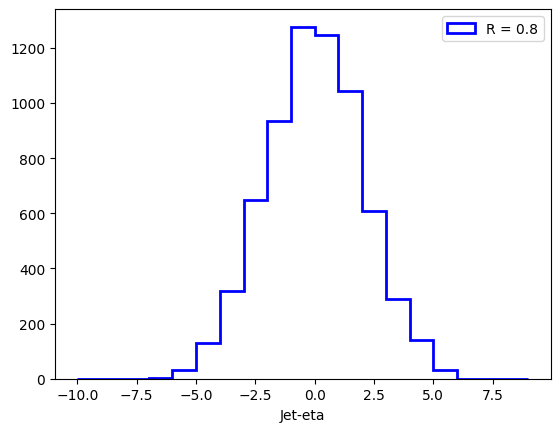

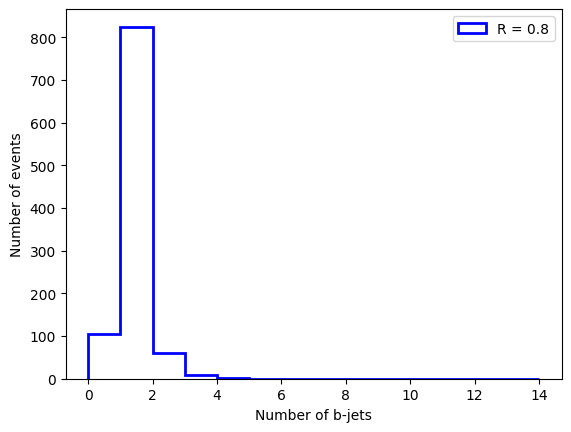

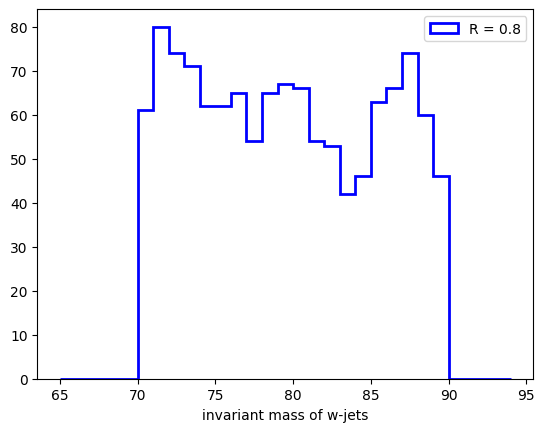

In [26]:
f(0.8)

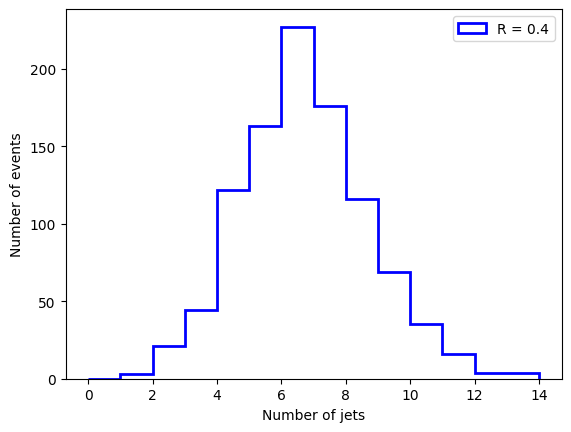

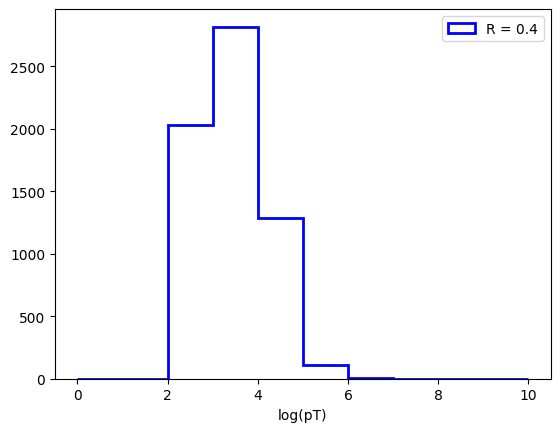

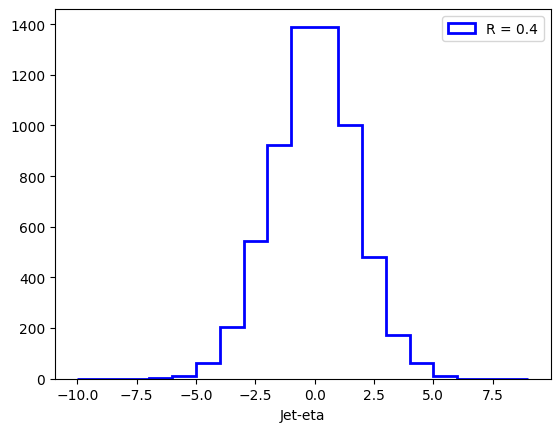

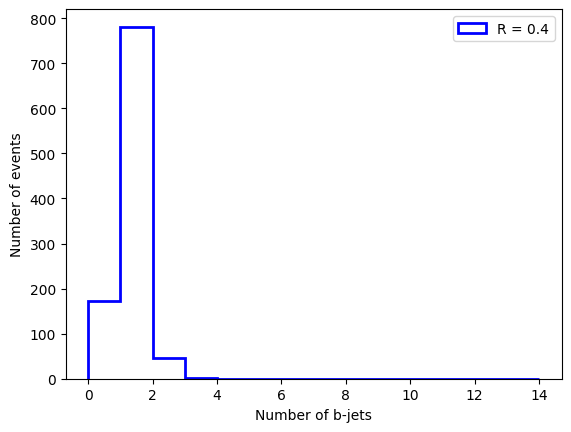

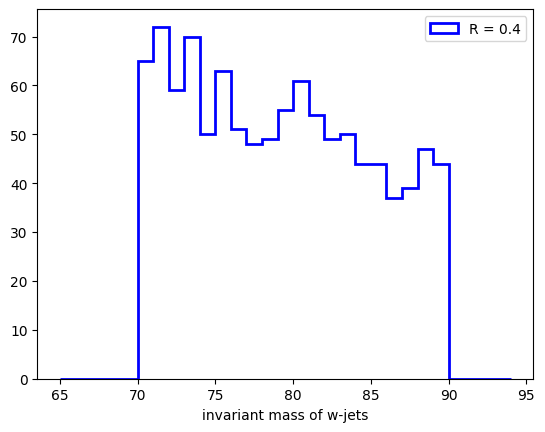

In [20]:
f(0.4)